In [82]:
#Import the required libraries
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)b
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error,r2_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gc
from tqdm import tqdm

In [83]:
#Load the files in to the local machine
sample_submission = pd.read_csv('../input/jobathon-may-2021-credit-card-lead-prediction/sample_submission.csv')
test =  pd.read_csv('../input/jobathon-may-2021-credit-card-lead-prediction/test.csv')
train = pd.read_csv( '../input/jobathon-may-2021-credit-card-lead-prediction/train.csv')

In [84]:
#Load the data or read the data 
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [85]:
#Check the test data
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


## Description of Dataset

- ID - IUnique Identifier for a row
- Gender- Gender of the Customer
- Age-Age of the Customer (in Years)
- Region_Code-Code of the Region for the customers
- Occupation-Occupation Type for the customer
- Channel_Code-Acquisition Channel Code for the Customer  (Encoded)
- Vintage-Vintage for the Customer (In Months)
- Credit_Product-If the Customer has any active credit product (Home loan,
Personal loan, Credit Card etc.)
- Avg_Account_Balance- Average Account Balance for the Customer in last 12 Months
- Is_Active-If the Customer is Active in last 3 Months

## No Of Records in the dataset

In [86]:
#Check the data type and the missing values in the columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [87]:
#Check as well as in test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int64 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int64 
 7   Credit_Product       92790 non-null   object
 8   Avg_Account_Balance  105312 non-null  int64 
 9   Is_Active            105312 non-null  object
dtypes: int64(3), object(7)
memory usage: 8.0+ MB


## get min max std deviation of the dataset /check quantiles

In [88]:
#Get the statistical information of the data like min,max,mean of the variables
train.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


In [89]:
test.describe()

,Age,Vintage,Avg_Account_Balance
count,105312.000000,105312.000000,1.053120e+05
mean,43.871002,46.842819,1.134195e+06
std,14.872890,32.273634,8.662430e+05
min,24.000000,7.000000,2.259700e+04
25%,30.000000,20.000000,6.039822e+05
50%,43.000000,32.000000,8.966345e+05
75%,54.000000,73.000000,1.371598e+06
max,85.000000,135.000000,9.908858e+06


In [90]:
#Check the how many of categories present in the eah variables
train.nunique()

ID                     245725
Gender                      2
Age                        63
Region_Code                35
Occupation                  4
Channel_Code                4
Vintage                    66
Credit_Product              2
Avg_Account_Balance    135292
Is_Active                   2
Is_Lead                     2
dtype: int64

In [91]:
#As per the instructions the target column is 'Is_Lead'
Target_col = 'Is_Lead'

In [92]:
#Categorical data Dtype= 'object'
categorical_vars = ['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']
conts = ['Age', 'Vintage', 'Avg_Account_Balance']

### Check the distributions of the numerical data

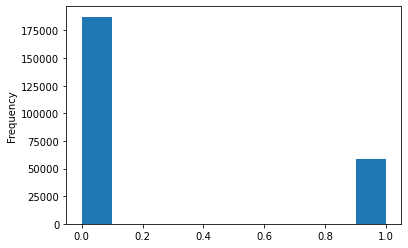

In [93]:
train.Is_Lead.plot.hist()

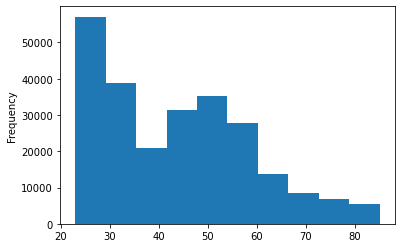

In [94]:
train.Age.plot.hist()

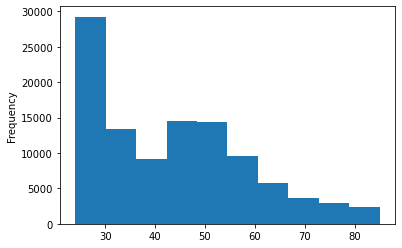

In [95]:
test.Age.plot.hist()

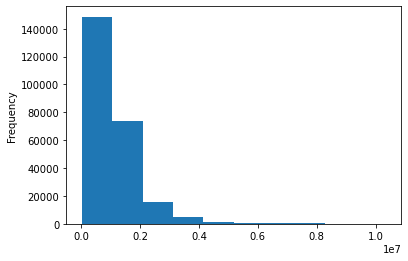

In [96]:
train.Avg_Account_Balance.plot.hist()

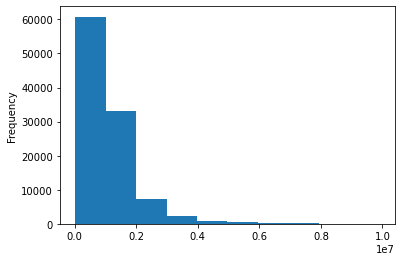

In [97]:
test.Avg_Account_Balance.plot.hist()

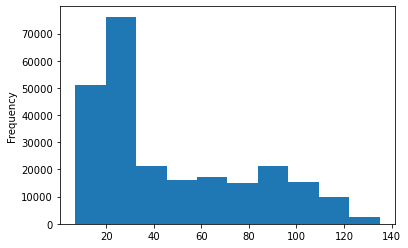

In [98]:
train.Vintage.plot.hist()

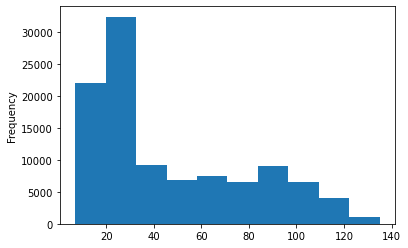

In [99]:
test.Vintage.plot.hist()

## outliers

In [100]:
train = train[train['Avg_Account_Balance']<=max(test.Avg_Account_Balance)].reset_index(drop=True)

In [101]:
for i in categorical_vars:
    print(train.groupby(i)['Is_Lead'].value_counts().nlargest(8))

Gender  Is_Lead
Male    0          98613
Female  0          88823
Male    1          35582
Female  1          22705
Name: Is_Lead, dtype: int64
Region_Code  Is_Lead
RG268        0          25160
RG254        0          21127
RG283        0          20531
RG284        0          13504
RG268        1          10773
RG277        0           9851
RG280        0           9766
RG283        1           8884
Name: Is_Lead, dtype: int64
Occupation     Is_Lead
Self_Employed  0          73045
Salaried       0          60503
Other          0          52983
Self_Employed  1          27841
Other          1          17189
Salaried       1          11496
Entrepreneur   1           1761
               0            905
Name: Is_Lead, dtype: int64
Channel_Code  Is_Lead
X1            0          94236
X2            0          45519
X3            0          43492
              1          25219
X2            1          22207
X1            1           9481
X4            0           4189
              1      

### All the Entrepreneur have credit card interest

## Missing value analysis

In [102]:
train.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [103]:
train = train.fillna('Yes')
test = test.fillna('Yes')

In [104]:
train['set'] = 1
test['set'] = 0
concat = pd.concat([train.drop(['ID'], axis=1), test.drop('ID', axis=1)])

In [105]:
results = concat[concat.duplicated(subset=['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage', 'Credit_Product', 'Is_Active'], keep=False)].sort_values(by=['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage', 'Credit_Product', 'Is_Active', 'Is_Lead']).fillna(method='ffill')

In [106]:
results

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,set
182425,Female,24,RG250,Other,X1,13,Yes,585192,No,0.0,1
245257,Female,24,RG250,Other,X1,13,Yes,385343,No,0.0,1
98560,Female,24,RG250,Salaried,X1,13,No,406667,No,0.0,1
131532,Female,24,RG250,Salaried,X1,13,No,757185,No,0.0,1
37595,Female,24,RG250,Salaried,X1,13,Yes,539598,No,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
231318,Male,85,RG284,Other,X3,98,Yes,1292742,Yes,0.0,1
20555,Male,85,RG284,Other,X3,98,Yes,884615,Yes,0.0,0
78906,Male,85,RG284,Other,X3,98,Yes,8799173,Yes,0.0,0
149351,Male,85,RG284,Other,X3,110,Yes,759801,Yes,0.0,1


In [107]:
train = train.drop('set', axis=1)
test = test.drop('set', axis=1)

## Feature Engeneering

In [108]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['Gender'])
train['Gender'] = le.transform(train['Gender'])
test['Gender'] = le.transform(test['Gender'])

In [109]:
from sklearn.preprocessing import LabelEncoder
ole = LabelEncoder()
ole.fit(train['Occupation'])
train['Occupation'] = ole.transform(train['Occupation'])
test['Occupation'] = ole.transform(test['Occupation'])

In [110]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['Channel_Code'])
train['Channel_Code'] = le.transform(train['Channel_Code'])
test['Channel_Code'] = le.transform(test['Channel_Code'])

In [111]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['Credit_Product'])
train['Credit_Product'] = le.transform(train['Credit_Product'])
test['Credit_Product'] = le.transform(test['Credit_Product'])

In [112]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['Is_Active'])
train['Is_Active'] = le.transform(train['Is_Active'])
test['Is_Active'] = le.transform(test['Is_Active'])

In [113]:
# performing freq encoding

dicto = train['Region_Code'].value_counts(normalize=True).to_dict()
train['Region_Code'] = train['Region_Code'].map(dicto)
dicto = test['Region_Code'].value_counts(normalize=True).to_dict()
test['Region_Code'] = test['Region_Code'].map(dicto)

In [114]:
from scipy import stats

In [115]:
fitted_data, fitted_lambda = stats.boxcox(np.abs(train['Vintage']))
train['Vintage_box'] = fitted_data
fitted_data, fitted_lambda = stats.boxcox(np.abs(test['Vintage']))
test['Vintage_box'] = fitted_data

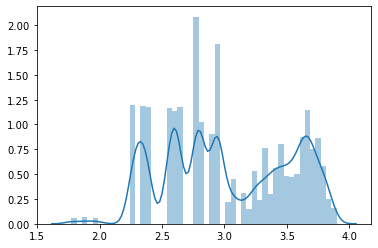

In [116]:
sns.distplot(fitted_data)

In [117]:
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
est.fit(train['Age'].values.reshape(-1,1))
train['Age_quantiles'] = est.transform(train['Age'].values.reshape(-1,1)).astype(int)
test['Age_quantiles'] = est.transform(test['Age'].values.reshape(-1,1)).astype(int)

In [118]:
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
est.fit(train['Vintage'].values.reshape(-1,1))
train['Vintage_quantiles'] = est.transform(train['Vintage'].values.reshape(-1,1)).astype(int)
test['Vintage_quantiles'] = est.transform(test['Vintage'].values.reshape(-1,1)).astype(int)

In [119]:
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
est.fit(train['Avg_Account_Balance'].values.reshape(-1,1))
train['Avg_Account_Balance_quantiles'] = est.transform(train['Avg_Account_Balance'].values.reshape(-1,1)).astype(int)
test['Avg_Account_Balance_quantiles'] = est.transform(test['Avg_Account_Balance'].values.reshape(-1,1)).astype(int)

In [120]:
train['Avg_Account_Balance_log'] = np.log(train['Avg_Account_Balance'])
test['Avg_Account_Balance_log'] = np.log(test['Avg_Account_Balance'])

train['Vintage_log'] = np.log(train['Vintage'])
test['Vintage_log'] = np.log(test['Vintage'])


In [121]:
conts

['Age', 'Vintage', 'Avg_Account_Balance']

In [122]:
train.describe()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Vintage_box,Age_quantiles,Vintage_quantiles,Avg_Account_Balance_quantiles,Avg_Account_Balance_log,Vintage_log
count,245723.000000,245723.000000,245723.000000,245723.000000,245723.000000,245723.000000,245723.000000,2.457230e+05,245723.000000,245723.000000,245723.000000,245723.000000,245723.000000,245723.000000,245723.000000,245723.000000
mean,0.546123,43.856220,0.067863,2.103295,0.902866,46.958807,0.412521,1.128329e+06,0.388380,0.237206,3.015499,3.562426,3.630116,3.500067,13.733401,3.606088
std,0.497869,14.828671,0.050077,0.853741,0.884839,32.353000,0.492289,8.525487e+05,0.487383,0.425371,0.493465,2.285578,2.235233,2.291308,0.619722,0.706473
min,0.000000,23.000000,0.006092,0.000000,0.000000,7.000000,0.000000,2.079000e+04,0.000000,0.000000,1.769996,0.000000,0.000000,0.000000,9.942227,1.945910
25%,0.000000,30.000000,0.021374,1.000000,0.000000,20.000000,0.000000,6.043100e+05,0.000000,0.000000,2.592438,2.000000,2.000000,2.000000,13.311843,2.995732
50%,1.000000,43.000000,0.052197,2.000000,1.000000,32.000000,0.000000,8.945920e+05,0.000000,0.000000,2.933844,4.000000,4.000000,4.000000,13.704123,3.465736
75%,1.000000,54.000000,0.119708,3.000000,2.000000,73.000000,1.000000,1.366648e+06,1.000000,0.000000,3.495839,6.000000,6.000000,6.000000,14.127872,4.290459
max,1.000000,85.000000,0.146234,3.000000,3.000000,135.000000,1.000000,9.792796e+06,1.000000,1.000000,3.885940,7.000000,7.000000,7.000000,16.097158,4.905275


In [123]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Vintage_box,Age_quantiles,Vintage_quantiles,Avg_Account_Balance_quantiles,Avg_Account_Balance_log,Vintage_log
0,NNVBBKZB,0,73,0.146234,1,2,43,0,1045696,0,0,3.140476,7,4,4,13.860193,3.761200
1,IDD62UNG,0,30,0.052197,2,0,32,0,581988,0,0,2.933844,2,4,1,13.274205,3.465736
2,HD3DSEMC,0,56,0.146234,3,2,26,0,1484315,1,0,2.784973,6,3,6,14.210464,3.258097
3,BF3NC7KV,1,34,0.031417,2,0,19,0,470454,0,0,2.554209,2,1,1,13.061453,2.944439
4,TEASRWXV,0,30,0.023722,2,0,33,0,886787,0,0,2.955647,2,4,3,13.695360,3.496508


In [124]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Vintage_box,Age_quantiles,Vintage_quantiles,Avg_Account_Balance_quantiles,Avg_Account_Balance_log,Vintage_log
0,VBENBARO,1,29,0.111450,1,0,25,1,742366,0,2.763079,1,2,3,13.517598,3.218876
1,CCMEWNKY,1,43,0.143621,1,1,49,1,925537,0,3.239120,4,4,4,13.738129,3.891820
2,VK3KGA9M,1,31,0.032665,2,0,14,0,215949,0,2.327128,2,0,0,12.282798,2.639057
3,TT8RPZVC,1,29,0.022201,1,0,33,0,868070,0,2.963264,1,4,3,13.674028,3.496508
4,SHQZEYTZ,0,29,0.032665,1,0,19,0,657087,0,2.559804,1,1,2,13.395572,2.944439


In [125]:
# join both train and test data for preprocessing..
train['train'] = 1
test['train'] = 0

df = pd.concat([train,test],axis=0).reset_index(drop=True)

In [126]:
# Create feature using count of each value, it will help to find most popular and least popular category in each feature

def encode_FE(df,col):
    cv = df[col].value_counts()
    nm = str(col)+'_FE'
    df[nm] = df[col].map(cv)

feats = [f for f in df.columns if f not in ['Response','train','ID']]
for col in feats:
    encode_FE(df,col)

In [127]:
# Find top 10 largest values and take it's sum.
def top_10_sum(x):
    return x.nlargest(10).sum()

# Find bottom 10 smallest values and take it's sum.
def bottom_10_sum(x):
    return x.nsmallest(10).sum()

# function to calculate mode..
def calc_mode(x):
    return pd.Series.mode(x)[0]

In [128]:
AGGREGATION_RECIPIES = [(['Channel_Code','Vintage'], 
                         [
                            ('Avg_Account_Balance', 'min'),
                            ('Avg_Account_Balance', 'mean'),
                             ('Avg_Account_Balance', 'max'),
                             ('Avg_Account_Balance', 'std'),
                             ('Avg_Account_Balance', 'skew')
                        ]
                        ),
                        (['Region_Code','Vintage'], 
                         [
                            ('Avg_Account_Balance', 'min'),
                            ('Avg_Account_Balance', 'mean'),
                             ('Avg_Account_Balance', 'max'),
                             ('Avg_Account_Balance', 'std'),
                             ('Avg_Account_Balance', 'skew'),
                             ('Avg_Account_Balance', top_10_sum),
                             ('Avg_Account_Balance', bottom_10_sum)
                         ]
                        ),
                        (['Region_Code'], 
                         [
                            ('Vintage', 'count'),
                            ('Vintage', 'min'),
                             ('Vintage', 'mean'),
                             ('Vintage', 'max'),
                             ('Vintage', 'std'),
                             ('Vintage', 'skew'),
                             ('Vintage', calc_mode)
                         ]
                        ),
                     (['Is_Active','Vintage'], 
                         [
                            ('Avg_Account_Balance', 'min'),
                            ('Avg_Account_Balance', 'mean'),
                             ('Avg_Account_Balance', 'max'),
                             ('Avg_Account_Balance', 'std'),
                         ]
                        ),
                        (['Credit_Product','Vintage'], 
                         [
                            ('Avg_Account_Balance', 'min'),
                            ('Avg_Account_Balance', 'mean'),
                             ('Avg_Account_Balance', 'max'),
                             ('Avg_Account_Balance', 'std'),
                         ]
                        ),
                        (['Vintage'], 
                         [
                            ('Avg_Account_Balance', 'min'),
                            ('Avg_Account_Balance', 'mean'),
                             ('Avg_Account_Balance', 'max'),
                             ('Avg_Account_Balance', 'std'),
                             ('Avg_Account_Balance', 'skew')
                         ]
                        ),
]

groupby_aggregate_names = []
for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
    group_object = df.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        df = df.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


## Modelling part

In [129]:
X = df[df['train']==1]
y = df[df['train']==1]['Is_Lead']
test_data = df[df['train']==0]

In [130]:
X = train.drop(['ID', 'Is_Lead', 'Avg_Account_Balance_quantiles', 'Vintage', 'Avg_Account_Balance','train'], axis=1).values
y = train[Target_col].values
X_test = test.drop(['ID', 'Avg_Account_Balance_quantiles', 'Vintage', 'Avg_Account_Balance','train'], axis=1).values


from sklearn.preprocessing import MaxAbsScaler

transformer = MaxAbsScaler().fit(X)
X = transformer.transform(X)
X_test = transformer.transform(X_test)

### Features selected for training

In [131]:
from sklearn.linear_model import Lasso, LinearRegression,Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC

In [132]:
from sklearn.metrics import roc_auc_score

In [133]:
from sklearn.model_selection import StratifiedKFold,KFold

In [134]:
!pip install catboost

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [135]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn import linear_model
from catboost import CatBoostClassifier

### XGboost

In [136]:
def entreprenur_make1(sample_submission):
  indexEntrepreneur = test[test['Occupation'] == list(ole.classes_).index('Entrepreneur')].index
  sample_submission.loc[indexEntrepreneur, 'Is_Lead'] = 1
  return sample_submission

In [138]:
predictions = np.zeros(test.shape[0])
oobs = np.zeros(train.shape[0])
y = train[Target_col].values
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
params = {'n_estimators': 20000, 'n_jobs': -1, 'random_state': 2, 'learning_rate': 0.014564209621859385, 'colsample_bytree': 0.48762749309989595}

model = lgb.LGBMClassifier(**params)
clf1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=10000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
    
for i, (train_id, valid_id) in enumerate(skf.split(X,y)):
    print("fold ", i)  
    X_train, y_train = X[train_id], y[train_id]
    X_valid, y_valid = X[valid_id], y[valid_id]
    clf1.fit(X_train, y_train, eval_set =[(X_valid, y_valid)],  early_stopping_rounds=200, verbose=1000, eval_metric='auc')

    oobs[valid_id] = clf1.predict_proba(X_valid)[:,1]
    predictions += clf1.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y,oobs)
finals = predictions/5
lgb_predictions = finals
sample_submission[Target_col] = finals
sample_submission.to_csv('xgb.csv', index=False)
print("ROCAUC", roc_auc)
lgb_oobs = oobs
print("best oob lightgbm")
pd.DataFrame(data=oobs).to_csv('oob_lgb.csv')

fold  0
[0]	validation_0-auc:0.83303
Will train until validation_0-auc hasn't improved in 200 rounds.
Stopping. Best iteration:
[144]	validation_0-auc:0.84945

fold  1
[0]	validation_0-auc:0.83505
Will train until validation_0-auc hasn't improved in 200 rounds.
Stopping. Best iteration:
[80]	validation_0-auc:0.85152

fold  2
[0]	validation_0-auc:0.83624
Will train until validation_0-auc hasn't improved in 200 rounds.
Stopping. Best iteration:
[109]	validation_0-auc:0.85143

fold  3
[0]	validation_0-auc:0.83463
Will train until validation_0-auc hasn't improved in 200 rounds.
Stopping. Best iteration:
[91]	validation_0-auc:0.85128

fold  4
[0]	validation_0-auc:0.83487
Will train until validation_0-auc hasn't improved in 200 rounds.
Stopping. Best iteration:
[64]	validation_0-auc:0.85199

ROCAUC 0.851086765358516
best oob lightgbm


### The Final score of ROC_AUC IS 0.851